In [2]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pickle

from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
# load data
df = pd.read_csv('Processed_data/all_data.csv',index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744870 entries, 0 to 744869
Data columns (total 13 columns):
claim_id        744870 non-null float64
enrollee_id     744870 non-null float64
provider_id     744870 non-null float64
hmo_id          744870 non-null float64
care_id         744870 non-null float64
diagnosis_id    744861 non-null float64
qty             744870 non-null float64
amount          744870 non-null float64
unit_price      744870 non-null float64
tariffs         668049 non-null float64
created_at      744870 non-null object
vetted_at       744870 non-null object
label           744870 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 79.6+ MB


## create month feature for claim created and vetted date

In [24]:
# check data format
df.iloc[0].created_at[5:7],df.iloc[0].created_at

('03', '2018-03-12 14:53:46')

In [25]:

df['create_m'] = df.created_at.apply(lambda x: x[5:7])
df['vetted_m'] = df.vetted_at.apply(lambda x: x[5:7])

## create feature for enrollee_id by cummulated claim number and amount

In [26]:
a = df.sort_values(by='created_at')[['claim_id','enrollee_id','created_at']]

In [27]:
a.head()

,claim_id,enrollee_id,created_at
0,10.0,89.0,2018-03-12 14:53:46
1,11.0,89.0,2018-03-13 14:50:39
2,13.0,74.0,2018-03-16 10:28:53
3,13.0,74.0,2018-03-16 10:28:53
4,13.0,74.0,2018-03-16 10:28:53


In [28]:
a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744870 entries, 0 to 744869
Data columns (total 3 columns):
claim_id       744870 non-null float64
enrollee_id    744870 non-null float64
created_at     744870 non-null object
dtypes: float64(2), object(1)
memory usage: 22.7+ MB


In [29]:
df['enrollee_cum_claim_count'] = a.groupby(['enrollee_id']).cumcount()+1

In [30]:
df.head()

,claim_id,enrollee_id,provider_id,hmo_id,care_id,diagnosis_id,qty,amount,unit_price,tariffs,created_at,vetted_at,label,create_m,vetted_m,enrollee_cum_claim_count
0,10.0,89.0,1.0,1.0,586.0,9.0,6.0,1816.08,302.68,302.68,2018-03-12 14:53:46,2018-05-21 10:05:30,0,03,05,1
1,11.0,89.0,1.0,1.0,586.0,15925.0,6.0,1816.08,302.68,302.68,2018-03-13 14:50:39,2018-05-21 10:07:19,0,03,05,2
2,13.0,74.0,1.0,1.0,434.0,4342.0,5.0,115.00,23.00,23.00,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,1
3,13.0,74.0,1.0,1.0,1102.0,4342.0,10.0,1265.00,126.50,126.50,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,2
4,13.0,74.0,1.0,1.0,299.0,4342.0,15.0,138.00,9.20,9.20,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,3


In [31]:
df['enrollee_cum_claim_amount'] = df.groupby(['enrollee_id'])['amount'].cumsum()

In [32]:
df.head()


,claim_id,enrollee_id,provider_id,hmo_id,care_id,diagnosis_id,qty,amount,unit_price,tariffs,created_at,vetted_at,label,create_m,vetted_m,enrollee_cum_claim_count,enrollee_cum_claim_amount
0,10.0,89.0,1.0,1.0,586.0,9.0,6.0,1816.08,302.68,302.68,2018-03-12 14:53:46,2018-05-21 10:05:30,0,03,05,1,1816.08
1,11.0,89.0,1.0,1.0,586.0,15925.0,6.0,1816.08,302.68,302.68,2018-03-13 14:50:39,2018-05-21 10:07:19,0,03,05,2,3632.16
2,13.0,74.0,1.0,1.0,434.0,4342.0,5.0,115.00,23.00,23.00,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,1,115.00
3,13.0,74.0,1.0,1.0,1102.0,4342.0,10.0,1265.00,126.50,126.50,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,2,1380.00
4,13.0,74.0,1.0,1.0,299.0,4342.0,15.0,138.00,9.20,9.20,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,3,1518.00


In [33]:
df_engineered = df[['claim_id','enrollee_id','enrollee_cum_claim_count','enrollee_cum_claim_amount','provider_id',\
                   'hmo_id','care_id','diagnosis_id','qty','amount','unit_price','tariffs','create_m','vetted_m','label']]

In [5]:
#df_engineered.to_csv('Processed_data/feature_engineered.csv')
#df_engineered = pd.read_csv('Processed_data/feature_engineered.csv')

In [6]:
# training and testing data
X = df_engineered.drop(columns=['claim_id','enrollee_id','label'])
y = df_engineered.label

In [36]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=2)

In [4]:
def init_scores():
    
    scores = {}
    scores['f1_socre'] = []
    scores['precision'] = []
    scores['recall'] = []
    scores['FPR'] = []
    scores['specificity'] = []
    scores['roc_auc'] = []
    
    return scores


def evaluation(ytest,Xtest,cls):

    scores = init_scores()
    ypred = cls.predict(Xtest)
    C = confusion_matrix(ytest,ypred)
    TN = C[0][0]
    FN = C[1][0]
    TP = C[1][1]
    FP = C[0][1]

    print('f1_socre: {:0.3f}'.format(f1_score(ytest,ypred)))
    scores['f1_socre'].append(f1_score(ytest,ypred))
    print('precision: {:0.3f}'.format(TP/(TP+FP)))
    scores['precision'].append(TP/(TP+FP))
    print('recall/sensitivity(true positive rate): {:0.3f}'.format(TP/(TP+FN)))
    scores['recall'].append(TP/(TP+FN))
    print('false positive rate (FPR): {:0.3f}'.format(1-(TN/(TN+FP)))) # 1 - specificity
    scores['FPR'].append(1-(TN/(TN+FP)))
    print('spcificity(true negative rate): {:0.3f}'.format(TN/(TN+FP)))
    scores['specificity'].append(TN/(TN+FP))
    print('ROC_AUC_score: {:0.3f}'.format(roc_auc_score(ytest,ypred)))
    scores['roc_auc'].append(roc_auc_score(ytest,ypred))
    
    return scores
    
def cv(Xtrain,ytrain,model):

    models = []
    kf = KFold(n_splits=4)
    print(model)
    n = 0
    for train_index, test_index in kf.split(Xtrain):
        print('cross_validate_run: {}'.format(n))
        Xtr, Xte = Xtrain[train_index], Xtrain[test_index]
        ytr, yte = ytrain[train_index], ytrain[test_index]
        cls = model.fit(Xtr, ytr) 
        models.append(cls)
        scores = evaluation(yte,Xte,cls)
        n += 1
    
    print('\n mean scores +/- sd: \n')
    for k in scores:
        print('{} : {:0.3f} +/- {:0.3f}'.format(k, np.array(scores[k]).mean(),  np.array(scores[k]).std()))
        
    
    return models, scores

In [41]:
# explore depth info
allmodels = []
allscores = []
for d in [5,10,15,20,25]:
    print("maximum depth: {}".format(d))
    lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=min(2**d-1,300), max_depth=d, learning_rate=0.1, \
                       n_estimators=300, subsample_for_bin=200000, objective=None, class_weight={1:50}, \
                       min_split_gain=0.0, min_child_weight=1, min_child_samples=1, subsample=1.0, \
                       subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=1, \
                       random_state=None, n_jobs=4, silent=True, importance_type='split',bagging_fraction=0.1,bagging_freq=10)
    

    lgb_models, lgb_scores = cv(Xtrain.values,ytrain.values,lgb)
    allmodels.append(lgb_models)
    allscores.append(lgb_scores)

maximum depth: 5
LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 50}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
cross_validate_run: 0
f1_socre: 0.157
precision: 0.086
recall/sensitivity(true positive rate): 0.900
false positive rate (FPR): 0.429
spcificity(true negative rate): 0.571
ROC_AUC_score: 0.736
cross_validate_run: 1
f1_socre: 0.162
precision: 0.089
recall/sensitivity(true positive rate): 0.900
false positive rate (FPR): 0.412
spcificity(true negative rate): 0.588
ROC_AUC_score: 0.744
cross_validate_run: 2
f1_socre: 0.164
precision: 0.090
recall/sensitivity(true positive ra

In [42]:
name = "Models/lightgbm/lgb_t"
d = [5,10,15,20,25]
for n, model in zip(d,allmodels):
    pickle.dump(model,open(name+str(n)+".dat", "wb"))

# upsampling

In [8]:

Xy = X.copy()
Xy['y'] = y

class0 = Xy.loc[Xy.y == 0]
class1 = Xy.loc[Xy.y == 1]
print(class0.shape,class1.shape)
class1 = class1.sample(n=class0.shape[0],replace=True,random_state=0)
Xy = pd.concat([class0,class1])
yup = Xy['y']
Xup = Xy.drop(columns=['y'])
# re-do train_test split of balanced data
Xuptrain,Xuptest,yuptrain,yuptest = train_test_split(Xup.values,yup.values,test_size = 0.2,random_state=42)

(713148, 14) (31722, 14)


In [44]:
allupmodels = []
allupscores = []
for d in [5,10,15,20]:
    print("maximum depth: {}".format(d))
    lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=min(2**d-1,300), max_depth=d, learning_rate=0.1, \
                       n_estimators=300, subsample_for_bin=200000, objective=None, class_weight={1:2}, \
                       min_split_gain=0.0, min_child_weight=1, min_child_samples=1, subsample=1.0, \
                       subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=1, \
                       random_state=None, n_jobs=4, silent=True, importance_type='split',bagging_fraction=0.1,bagging_freq=10)
    

    lgb_models, lgb_scores = cv(Xuptrain,yuptrain,lgb)
    allupmodels.append(lgb_models)
    allupscores.append(lgb_scores)

maximum depth: 5
LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
cross_validate_run: 0
f1_socre: 0.826
precision: 0.734
recall/sensitivity(true positive rate): 0.945
false positive rate (FPR): 0.341
spcificity(true negative rate): 0.659
ROC_AUC_score: 0.802
cross_validate_run: 1
f1_socre: 0.825
precision: 0.733
recall/sensitivity(true positive rate): 0.943
false positive rate (FPR): 0.343
spcificity(true negative rate): 0.657
ROC_AUC_score: 0.800
cross_validate_run: 2
f1_socre: 0.826
precision: 0.735
recall/sensitivity(true positive rat

In [45]:
name = "Models/lightgbm/lgb_up_t"
d = [5,10,15,20]
for n, model in zip(d,allmodels):
    pickle.dump(model,open(name+str(n)+".dat", "wb"))

In [46]:
for d in [25,30]:
    print("maximum depth: {}".format(d))
    lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=min(2**d-1,300), max_depth=d, learning_rate=0.1, \
                       n_estimators=300, subsample_for_bin=200000, objective=None, class_weight={1:2}, \
                       min_split_gain=0.0, min_child_weight=1, min_child_samples=1, subsample=1.0, \
                       subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=1, \
                       random_state=None, n_jobs=4, silent=True, importance_type='split',bagging_fraction=0.1,bagging_freq=10)
    
    lgb_models, lgb_scores = cv(Xuptrain,yuptrain,lgb)
    allmodels.append(lgb_models)
    allscores.append(lgb_scores)

maximum depth: 25
LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=25,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
cross_validate_run: 0
f1_socre: 0.961
precision: 0.925
recall/sensitivity(true positive rate): 0.998
false positive rate (FPR): 0.080
spcificity(true negative rate): 0.920
ROC_AUC_score: 0.959
cross_validate_run: 1
f1_socre: 0.962
precision: 0.928
recall/sensitivity(true positive rate): 0.998
false positive rate (FPR): 0.078
spcificity(true negative rate): 0.922
ROC_AUC_score: 0.960
cross_validate_run: 2
f1_socre: 0.962
precision: 0.928
recall/sensitivity(true positive 

# Evaluation by testing data

In [47]:
best_model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [48]:
best_model.fit(Xuptrain,yuptrain)

LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [49]:
testscores = evaluation(yuptest,Xuptest,best_model)

f1_socre: 0.963
precision: 0.929
recall/sensitivity(true positive rate): 0.999
false positive rate (FPR): 0.077
spcificity(true negative rate): 0.923
ROC_AUC_score: 0.961


# plot model performence

In [14]:
def plot_roc_curves(curves,colors,labels):
    plt.plot([0,0.5,1],[0,0.5,1], linestyle='--', color = 'black') # default classification bound
    
    for i in range(len(curves)):
        fpr, tpr, _ = curves[i]
        plt.plot(fpr,tpr,color=colors[i],linewidth=2,label=labels[i])
    
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)

    plt.show()
    

In [51]:
allmodels[2][0]

LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [52]:
predd5 = allmodels[0][0].predict_proba(Xuptest)
predd10 = allmodels[1][0].predict_proba(Xuptest)

In [53]:
curve5 = roc_curve(yuptest, predd5[:,1])
curve10 = roc_curve(yuptest,predd10[:,1])
curve15 = roc_curve(yuptest,best_model.predict_proba(Xuptest)[:,1])

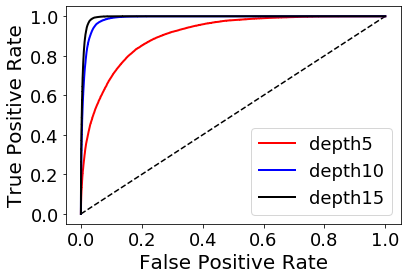

In [54]:
plot_roc_curves([curve5, curve10, curve15],['red','blue','black'],['depth5','depth10','depth15'])


In [13]:
# plot importance
import lightgbm

def feature_importance(model,columns):
    # Plot importance for beset model: model_mse
    fig, ax = plt.subplots(figsize=(15,5))

    g1 = lightgbm.plot_importance(model,ax=ax,grid=False)

    oldy = g1.yaxis.get_majorticklabels()
    feature_dict = dict(zip(['Column_'+str(i) for i in range(len(columns))], columns))
    newy = [feature_dict[y._text] for y in oldy]
    g1.set_yticklabels(newy,rotation=0,fontsize=18)

    #fig.savefig('feature_importance.jpg')
    plt.title('Feature Importance',fontsize=26)
    plt.xlabel('Feature importance',fontsize = 24)
    plt.ylabel('Features', fontsize = 24)
    plt.show()

In [56]:
columns = ['enrollee_cum_claim_count', 'enrollee_cum_claim_amount', 'provider',
       'insurance_policy', 'care', 'diagnosis', 'qty', 'claim amount', 'care_price',
       'tariffs', 'claim month', 'vetted_month']

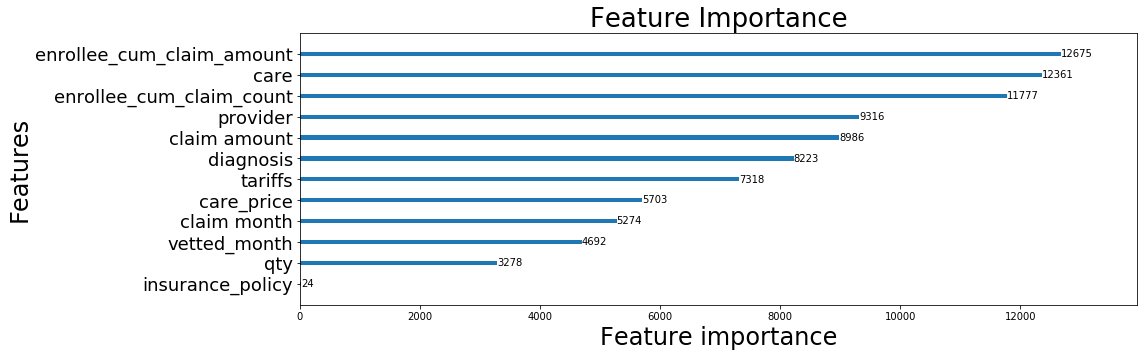

In [57]:
feature_importance(allmodels[2][0],columns)

### Further validating feature importance

In [83]:
# drop diagnosis
# train test split
X1 = Xup.drop(columns=['diagnosis_id'])
X1train,X1test,y1train,y1test = train_test_split(X1,yup,test_size = 0.2, random_state=42)

In [10]:
# model
best_model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [86]:
# fit model
best_model.fit(X1train.values,y1train.values)

LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [87]:
# test score validation
test1 = evaluation(y1test.values,X1test.values,best_model)

f1_socre: 0.963
precision: 0.930
recall/sensitivity(true positive rate): 0.998
false positive rate (FPR): 0.076
spcificity(true negative rate): 0.924
ROC_AUC_score: 0.961


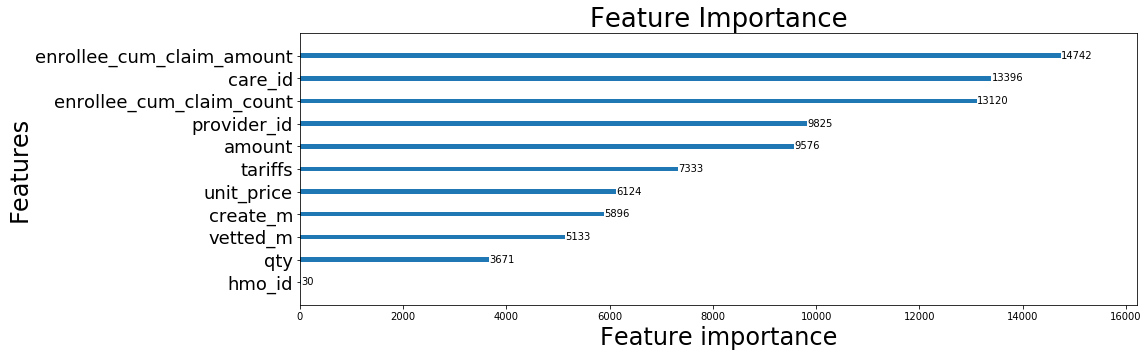

In [88]:
# plot feature importance
feature_importance(best_model,X1train.columns)

In [89]:
# roc_curve
nodiag = roc_curve(y1test,best_model.predict_proba(X1test.values)[:,1])

In [90]:
# save model
pickle.dump(best_model,open("Models/lightgbm/lgb_noDiag.dat", "wb"))

f1_socre: 0.961
precision: 0.926
recall/sensitivity(true positive rate): 0.999
false positive rate (FPR): 0.080
spcificity(true negative rate): 0.920
ROC_AUC_score: 0.959


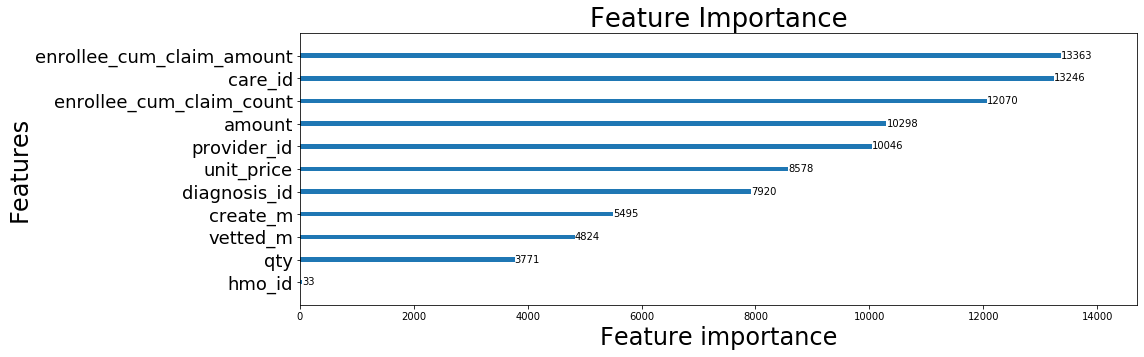

In [91]:
# drop tariffs
X2 = Xup.drop(columns=['tariffs'])
X2train,X2test,y2train,y2test = train_test_split(X2,yup,test_size = 0.2, random_state=42)
model2 = best_model
model2.fit(X2train.values,y2train.values)
test2 = evaluation(y2test.values,X2test.values,model2)
feature_importance(model2,X2train.columns)

In [92]:
# roc_curve and save model
notarif = roc_curve(y2test,model2.predict_proba(X2test.values)[:,1])
pickle.dump(model2,open("Models/lightgbm/lgb_noTariff.dat", "wb"))

In [17]:
# drop enrollee
X3 = Xup.drop(columns=['enrollee_cum_claim_count','enrollee_cum_claim_amount'])
X3train,X3test,y3train,y3test = train_test_split(X3,yup,test_size = 0.2, random_state=42)


In [94]:
model3 = best_model
model3.fit(X3train.values,y3train.values)
test3 = evaluation(y3test.values,X3test.values,model3)
feature_importance(model3,X3train.columns)
# roc_curve and save model
noenro = roc_curve(y3test,model3.predict_proba(X3test.values)[:,1])
pickle.dump(model3,open("Models/lightgbm/lgb_noEnrollee.dat", "wb"))

f1_socre: 0.926
precision: 0.871
recall/sensitivity(true positive rate): 0.989
false positive rate (FPR): 0.147
spcificity(true negative rate): 0.853
ROC_AUC_score: 0.921


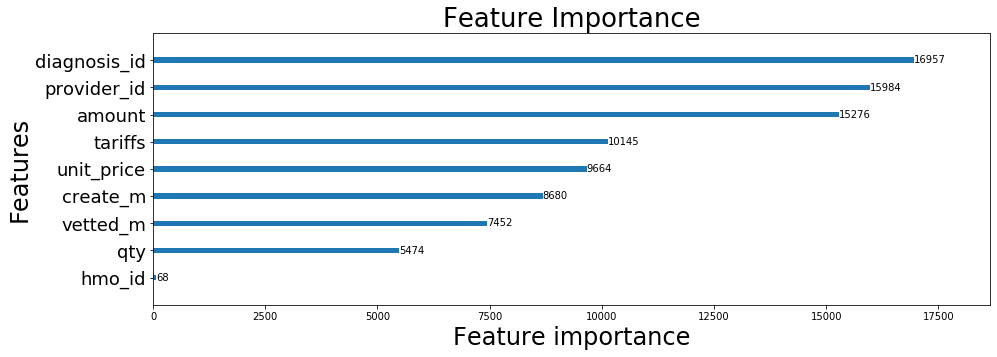

In [103]:
# drop enrollee_care

X5 = Xup.drop(columns=['enrollee_cum_claim_count','enrollee_cum_claim_amount','care_id'])
X5train,X5test,y5train,y5test = train_test_split(X5,yup,test_size = 0.2, random_state=42)
model5 = best_model
model5.fit(X5train.values,y5train.values)
test5 = evaluation(y5test.values,X5test.values,model5)
feature_importance(model5,X5train.columns)
no2 = roc_curve(y5test,model5.predict_proba(X5test.values)[:,1])
pickle.dump(model5,open("Models/lightgbm/lgb_noEnrolleeOrCare.dat", "wb"))